# Visualizing relationship growth

In Orrery, relationships develop as a function of time, the current relationship state, and characters disposition toward each other. 

This notebook visualizes the change in relationship values over time.

In [1]:
%matplotlib inline
import time
from typing import Any, Dict

import matplotlib.pyplot as plt

from orrery import Component, GameObject, ISystem, Orrery, OrreryConfig, SimDateTime
from orrery.components import GameCharacter, Relationship, RelationshipManager, Virtues
from orrery.core.status import StatusComponent
from orrery.data_collection import DataCollector
from orrery.exporter import export_to_json
from orrery.utils.common import (
    add_character_to_settlement,
    spawn_business,
    spawn_character,
    spawn_settlement,
    start_job,
)
from orrery.utils.relationships import (
    add_relationship,
    add_relationship_status,
    get_relationship,
)


In [2]:
sim = Orrery(
    OrreryConfig.parse_obj(
        {
            "seed": 3,
            "relationship_schema": {
                "stats": {
                    "Friendship": {
                        "min_value": -100,
                        "max_value": 100,
                        "changes_with_time": True,
                    },
                    "Romance": {
                        "min_value": -100,
                        "max_value": 100,
                        "changes_with_time": True,
                    },
                },
            },
            "plugins": [
                "orrery.plugins.default.names",
                "orrery.plugins.default.characters",
                "orrery.plugins.default.businesses",
                "orrery.plugins.default.residences",
                "orrery.plugins.default.life_events",
                "orrery.plugins.default.ai",
            ],
        }
    )
)

In [3]:
@sim.component()
class Robot(Component):
    """Tags a character as a Robot"""

    def to_dict(self) -> Dict[str, Any]:
        return {}


@sim.component()
class OwesDebt(StatusComponent):
    """Marks a character as owing money to another character"""

    def __init__(self, amount: int) -> None:
        super().__init__()
        self.amount: int = amount

    def to_dict(self) -> Dict[str, Any]:
        return {"amount": self.amount}


@sim.social_rule("virtue compatibility")
def rule(subject: GameObject, target: GameObject) -> Dict[str, int]:
    if not subject.has_component(Virtues):
        return {}

    if not target.has_component(Virtues):
        return {}

    character_virtues = subject.get_component(Virtues)
    acquaintance_virtues = target.get_component(Virtues)

    compatibility = character_virtues.compatibility(acquaintance_virtues)

    romance_buff: int = 0
    friendship_buff: int = 0

    if compatibility < -0.5:
        romance_buff = -2
        friendship_buff = -3
    elif compatibility < 0:
        romance_buff = -1
        friendship_buff = -2
    elif compatibility > 0:
        romance_buff = 1
        friendship_buff = 2
    elif compatibility > 0.5:
        romance_buff = 2
        friendship_buff = 3

    return {"Friendship": friendship_buff, "Romance": romance_buff}


@sim.system()
class RelationshipReporter(ISystem):
    sys_group = "data-collection"

    def process(self, *args: Any, **kwargs: Any) -> None:
        timestamp = self.world.get_resource(SimDateTime).to_iso_str()
        data_collector = self.world.get_resource(DataCollector)
        for guid, (game_character, relationship_manager) in self.world.get_components(
            (GameCharacter, RelationshipManager)
        ):
            if game_character.first_name == "Delores":
                for target_id, rel_id in relationship_manager.relationships.items():
                    relationship = self.world.get_gameobject(rel_id).get_component(
                        Relationship
                    )
                    data_collector.add_table_row(
                        "relationships",
                        {
                            "timestamp": timestamp,
                            "owner": guid,
                            "target": target_id,
                            "friendship": relationship["Friendship"].get_value(),
                            "romance": relationship["Romance"].get_value(),
                        },
                    )

In [4]:
sim.world.get_resource(DataCollector).create_new_table(
    "relationships", ("timestamp", "owner", "target", "friendship", "romance")
)

west_world = spawn_settlement(sim.world, "West World")

delores = spawn_character(
    sim.world,
    "character::default::female",
    first_name="Delores",
    last_name="Abernathy",
    age=32,
)

delores.add_component(Robot())

add_character_to_settlement(delores, west_world)

charlotte = spawn_character(
    sim.world,
    "character::default::female",
    first_name="Charlotte",
    last_name="Hale",
    age=40,
)

add_character_to_settlement(charlotte, west_world)

william = spawn_character(
    sim.world,
    "character::default::male",
    first_name="William",
    last_name="ManInBlack",
    age=68,
)

add_character_to_settlement(william, west_world)

cafe = spawn_business(sim.world, "business::default::cafe", "Starbucks - WW")

start_job(delores, cafe, "Owner", is_owner=True)

add_relationship(delores, charlotte)
get_relationship(delores, charlotte)["Friendship"] += -1
get_relationship(delores, charlotte)["Friendship"] += 1

add_relationship_status(delores, charlotte, OwesDebt(500))

add_relationship(delores, william)
get_relationship(delores, william)["Romance"] += 4
get_relationship(delores, william)["Romance"] += -7
get_relationship(delores, william)["Interaction"] += 1

add_relationship(william, delores)
get_relationship(william, delores)["Interaction"] += 1

st = time.time()
sim.run_for(50)
elapsed_time = time.time() - st

print(f"World Date: {str(sim.world.get_resource(SimDateTime))}")
print("Execution time: ", elapsed_time, "seconds")

NewSettlementEvent [at 0001-01-01T00:00.000z] Settlement: West World
NewCharacterEvent [at 0001-01-01T00:00.000z] Character: Delores Abernathy
JoinSettlementEvent [at 0001-01-01T00:00.000z] Settlement: West World, Character: Delores Abernathy
NewCharacterEvent [at 0001-01-01T00:00.000z] Character: Charlotte Hale
JoinSettlementEvent [at 0001-01-01T00:00.000z] Settlement: West World, Character: Charlotte Hale
NewCharacterEvent [at 0001-01-01T00:00.000z] Character: William ManInBlack
JoinSettlementEvent [at 0001-01-01T00:00.000z] Settlement: West World, Character: William ManInBlack
NewBusinessEvent [at 0001-01-01T00:00.000z] Business: Starbucks - WW
StartJobEvent [at 0001-01-01T00:00.000z], character=Delores Abernathy, business=Starbucks - WW, occupation=Owner
NewResidenceEvent [at 0001-01-01T00:00.000z] Residence: GameObject(9)
NewCharacterEvent [at 0001-01-01T00:00.000z] Character: Jacquette Cookson
NewCharacterEvent [at 0001-01-01T00:00.000z] Character: Nicoline Cookson
NewCharacterEv

BecomeSeniorEvent [at 0026-01-01T00:00.000z] Character: Charlotte Hale
BecomeAdultEvent [at 0031-02-01T00:00.000z] Character: Theadora Cookson
BecomeAdultEvent [at 0031-02-01T00:00.000z] Character: Lillian Farro
BecomeAdultEvent [at 0031-02-01T00:00.000z] Character: Brett Farro
BecomeAdultEvent [at 0031-02-01T00:00.000z] Character: Jackie Edson
BecomeAdultEvent [at 0031-02-01T00:00.000z] Character: Denver Churches
BecomeAdultEvent [at 0031-08-01T00:00.000z] Character: Kellen Turney
BecomeAdultEvent [at 0031-08-01T00:00.000z] Character: Dafna Askin
BecomeAdultEvent [at 0031-08-01T00:00.000z] Character: River Askin
BecomeAdultEvent [at 0031-08-01T00:00.000z] Character: Tanney Askin
BecomeAdultEvent [at 0031-08-01T00:00.000z] Character: Malcah Deen
BecomeSeniorEvent [at 0034-01-01T00:00.000z] Character: Delores Abernathy
BecomeSeniorEvent [at 0036-01-01T00:00.000z] Character: Nicoline Cookson
BecomeSeniorEvent [at 0036-01-01T00:00.000z] Character: Reese Farro
BecomeSeniorEvent [at 0036-07

In [5]:
relationships_df = sim.world.get_resource(DataCollector).get_table_dataframe("relationships")

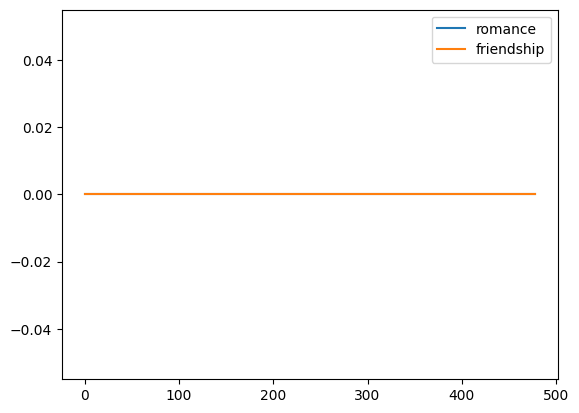

In [9]:
df = relationships_df.loc[relationships_df.target == 3].iloc[:240]
df.plot(y=["romance", "friendship"])
plt.show()